In [1]:
import s3fs
import hvac
import os

client = hvac.Client(url='https://vault.lab.sspcloud.fr',
                     token=os.environ['VAULT_TOKEN'])
secret = os.environ['VAULT_MOUNT'] + os.environ['VAULT_TOP_DIR'] + '/s3_creds'
mount_point, secret_path = secret.split('/', 1)
secret_dict = client.secrets.kv.read_secret_version(path=secret_path, mount_point = mount_point)
os.environ["AWS_ACCESS_KEY_ID"] = secret_dict['data']['data']['ACCESS_KEY']
os.environ["AWS_SECRET_ACCESS_KEY"] = secret_dict['data']['data']['SECRET_KEY']
try:
    del os.environ['AWS_SESSION_TOKEN']
except KeyError:
    pass

In [2]:
import pickle
import json
import mlflow
import os
import sys
sys.path.append("../src/")
sys.path.append("../")
sys.path.append("../src/page_selection/")
from tqdm import tqdm
from time import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
from utils import (
    clean_page_content,
    extract_document_content,
    fit_transform_vectorizer,
    train_random_forest,
)
from model_wrapper import RandomForestWrapper

### Nos données annotées

In [3]:
# TODO: clean up
with open("../data/updated_labels_filtered.json", "r") as fp:
    labels = json.load(fp)

In [7]:
labeled_file_names = []
valid_labels = []

i = 0
for file_name, file_labels in labels.items():
    # Keep documents with at least 1 table
    table_count = sum(file_labels)
    if table_count > 0:
        i += 1
        labeled_file_names.append(file_name)
        for label in file_labels:
            valid_labels.append(label)

In [8]:
corpus = []
labeled_file_names = [
    "projet-extraction-tableaux/raw-comptes/CS_extrait/" + file_name
    for file_name in labeled_file_names
]

In [9]:
for file_name in tqdm(labeled_file_names):
    clean_document_content = []
    page_list = extract_document_content(file_name, resolution=50)
    for page in page_list:
        clean_content = clean_page_content(page)
        clean_document_content.append(clean_content)
    corpus.append(clean_document_content)

100%|██████████| 36/36 [03:54<00:00,  6.51s/it]


In [10]:
corpus[0]

['vid',
 'g r e f f e u r i b u a e o e r e e g r e o b edat 14082020depot compt annuel depot b2020010356 gestion 2004b00488 siren rc grenoblel greffi tribunal commerc grenobl certif avoir proced depot annex dossi registr commerc societ fromager letoile38680 saintjustdeclaixdat clotur 31122019ce depot comprend docu comptabl prevus legisl vigueurconcern even rc suiv depot compt annuel',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'vid',
 'sas fromager letoil i bilan a bilan actif rubriqu mont brut amort prov net net capital souscr non appel immobilis incorporel frais detabl frais developp concess brevet droit similair fond commercial autr immobilis incorporel avanc acompt immo incorporel immobilis corporel terrain construct install techniqu mat outillag autr immobilis corporel immobilis cour avanc acompt immobilis financier 

In [11]:
flat_corpus = [item for sublist in corpus for item in sublist]

In [12]:
flat_corpus[:5]

['vid',
 'g r e f f e u r i b u a e o e r e e g r e o b edat 14082020depot compt annuel depot b2020010356 gestion 2004b00488 siren rc grenoblel greffi tribunal commerc grenobl certif avoir proced depot annex dossi registr commerc societ fromager letoile38680 saintjustdeclaixdat clotur 31122019ce depot comprend docu comptabl prevus legisl vigueurconcern even rc suiv depot compt annuel',
 'vid',
 'vid',
 'vid']

In [13]:
valid_labels[:5]

[0, 0, 0, 0, 0]

In [14]:
len(flat_corpus) == len(valid_labels)

True

### Données Adem + Laura

In [5]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
with fs.open("s3://projet-extraction-tableaux/data/df_trainrf.pickle", 'rb') as f:
    df = pickle.load(f)

In [6]:
df

,siren,pagenumber,text,tableau_f_et_p,accOCR,tableauPDF
0,5820378,1,RCS : AMIENS Code greffe : 8002 Documents comp...,0,"85,7764666501213",1
1,5820378,2,GREFFE DU TRIBUNAL DE COMMERCE …… D'AMIENS Dat...,0,"91,6485136349996",1
2,5820378,3,...,0,NaN,1
3,5820378,4,...,0,NaN,1
4,5820378,5,...,0,NaN,1
...,...,...,...,...,...,...
34906,998823504,45,4.9. Analyse et échéance des dettes\r\r\n...,0,NaN,1
34907,998823504,46,- de remboursement de pénalités et intérêts...,0,NaN,1
34908,998823504,47,6.2.2. ...,0,NaN,1
34909,998823504,48,ADECCO FRANCE Société par actions simplifiée a...,0,"91,7648922486163",1


In [18]:
flat_corpus2 = list(df.text)
valid_labels2 = list(df.tableau_f_et_p)

In [19]:
len(flat_corpus2) == len(valid_labels2)

True

In [ ]:
flat_corpus2[:5]

In [21]:
valid_labels2[:5]

[0, 0, 0, 0, 0]

In [22]:
flat_corpus2 = [clean_page_content(page) for page in flat_corpus2]

In [23]:
flat_corpus2[:5]

['rc amien cod greff docu comptabl registr commerc societ greffi tribunal commerc amien attest lexactitud inform transmis ciapres natur docu docu comptabl numero gestion b numero siren nom denomin entrefpris demousel depot enregistr sous numero depot e2020002813',
 'greff tribunal commerc damien dat depot compt annuel depot b2020002813 gestion 1958b70037 siren rc amien greffi tribunal commerc damien certif avoir proced depot annex dossi registr commerc societ entrepris demousel ru chateau deau zon industriel abbevill dat clotur depot comprend docu comptabl prevus legisl vigueur concern even rc suiv depot compt annuel',
 'bilan actif dgfip formulair obligatoir articl a cod general impot design lentrepris entrepris demousel dur lexercic exprim nombr mois adress lentrepris ru chateau deau abbevill cedex dur lexercic precedent numero siret ne exercic clos brut amort provis net capital souscr non appel i aa immobilis incorporel frais detabl ab ac frais developp cx cq concess brevet droit si

#### Alternative way of splitting train / test

In [47]:
train_siren, test_siren = train_test_split(df[df.tableau_f_et_p == 1]["siren"].unique())

In [49]:
train_df = df[df.siren.isin(train_siren)]
test_df = df[df.siren.isin(test_siren)]

In [50]:
train_corpus = list(train_df.text)
train_labels = list(train_df.tableau_f_et_p)

In [51]:
vectorizer, vectorized_corpus = fit_transform_vectorizer(train_corpus)

In [53]:
test_corpus = list(test_df.text)
test_labels = list(test_df.tableau_f_et_p)
vectorized_test = vectorizer.transform(test_corpus)

In [56]:
# Training classifier
params = {
    "n_estimators": 100,
    "criterion": "gini",
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
}

clf, clf_descr, train_time = train_random_forest(
    params, vectorized_corpus, train_labels
)

In [57]:
# Test time
t0 = time()
pred = clf.predict(vectorized_test)
test_time = time() - t0
# Score
accuracy = metrics.accuracy_score(test_labels, pred)
f1 = metrics.f1_score(test_labels, pred)
precision = metrics.precision_score(test_labels, pred)
recall = metrics.recall_score(test_labels, pred)
cm = metrics.confusion_matrix(test_labels, pred)

In [58]:
accuracy, f1, precision, recall

(0.9908995449772489, 0.21212121212121213, 0.7, 0.125)

Text(0.5, 1.0, 'Confusion Matrix')

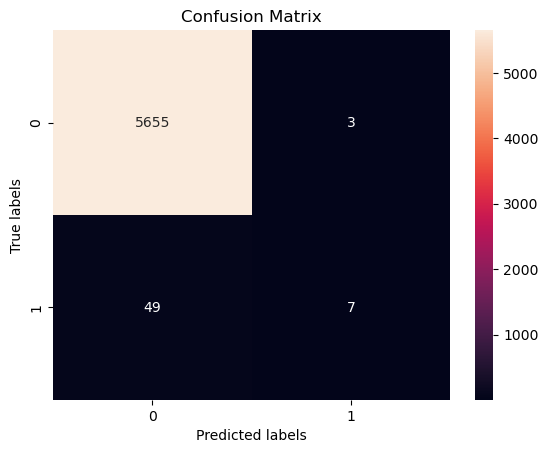

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

### Flattening, vectorizing

On fait les choses différemment ici mais pb: on fit le vectorizer sur le test, ce qui ne devrait pas être le cas.

In [34]:
vectorizer, vectorized_corpus = fit_transform_vectorizer(flat_corpus)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    vectorized_corpus, valid_labels, test_size=0.2, random_state=42
)

In [36]:
X_train

<1733x24497 sparse matrix of type '<class 'numpy.float64'>'
	with 96419 stored elements in Compressed Sparse Row format>

In [37]:
# Training classifier
params = {
    "n_estimators": 100,
    "criterion": "gini",
    "max_depth": None,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
}

clf, clf_descr, train_time = train_random_forest(
    params, X_train, y_train
)

In [38]:
clf

RandomForestClassifier()

In [39]:
# Test time
t0 = time()
pred = clf.predict(X_test)
test_time = time() - t0
# Score
accuracy = metrics.accuracy_score(y_test, pred)
f1 = metrics.f1_score(y_test, pred)
precision = metrics.precision_score(y_test, pred)
recall = metrics.recall_score(y_test, pred)
cm = metrics.confusion_matrix(y_test, pred)

In [40]:
accuracy, f1, precision, recall

(0.9746543778801844, 0.4210526315789474, 1.0, 0.26666666666666666)

Text(0.5, 1.0, 'Confusion Matrix')

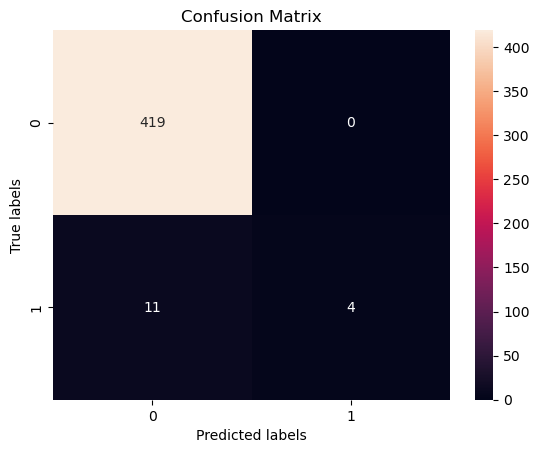

In [41]:
from matplotlib import pyplot as plt
import seaborn as sns

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')